In [1]:
import numpy as np 
import pandas as pd 
from sklearn import model_selection
import keras
from keras import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.optimizers import SGD

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from sklearn.model_selection import train_test_split


#import cv2
from PIL import Image
import glob
import os
import csv
from tqdm import tqdm

import sys
import shutil
from pathlib import Path
import tensorflow as tf


Using TensorFlow backend.


In [ ]:
#Connessione a Google Drive, rende possibile accedere a file e cartelle contenuti in 'Il mio Drive' 
#Eseguire solo se i dataset sono salvati non in locale ma in Google drive
from google.colab import drive
drive.mount('/content/drive')

In [7]:
Label = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
} 

In [8]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

# Preparazione dati

In [9]:
datagen = ImageDataGenerator(
              width_shift_range=0.2,
              height_shift_range=0.2,
              rescale=1./255,
              shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True,
              fill_mode='nearest')
)

datagenValidation = ImageDataGenerator(rescale=1./255)


In [10]:
img_width=224
img_height=224
batch_size=16

In [11]:
path_train=r"/content/drive/My Drive/multi_class_dataset/train/"
train_it = datagen.flow_from_directory(path_train, target_size=(img_width,img_height), color_mode='rgb', 
                                            class_mode='categorical', batch_size=16, shuffle=True, seed= 42)
path_val=r"/content/drive/My Drive/multi_class_dataset/validation/"
val_it = datagenValidation.flow_from_directory(path_val, target_size=(img_width,img_height), color_mode='rgb', 
                                            class_mode='categorical', batch_size=16, shuffle=False, seed= 42)
path_test=r"/content/drive/My Drive/multi_class_dataset/test/"
test_it = datagenValidation.flow_from_directory(path_test, target_size=(img_width,img_height), color_mode='rgb', 
                                            class_mode='categorical', batch_size=1, shuffle=False, seed= 42)
train_size = train_it.n
validation_size=val_it.n


Found 1445 images belonging to 20 classes.
Found 179 images belonging to 20 classes.
Found 179 images belonging to 20 classes.


In [12]:
train_steps = train_size//train_it.batch_size
valid_steps = validation_size//val_it.batch_size
callbacks = [EarlyStopping(monitor='val_loss', patience=2,verbose=0,restore_best_weights=True)]

In [13]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_generator = test_datagen.flow_from_directory(
    directory = r"/content/drive/My Drive/multi_class_dataset/test/",
    target_size = (img_width,img_height),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = None,
    shuffle = False
)

Found 179 images belonging to 20 classes.


# Definizione modello e addestramento

In [14]:
from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7fabf40598d0> False
<keras.layers.convolutional.Conv2D object at 0x7fabf40619b0> False
<keras.layers.convolutional.Conv2D object at 0x7fabf4061940> False
<keras.layers.pooling.MaxPooling2D object at 0x7fabf4077748> False
<keras.layers.convolutional.Conv2D object at 0x7fabf4077978> False
<keras.layers.convolutional.Conv2D object at 0x7fabf8fe36a0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fabf8ffcc18> False
<keras.layers.convolutional.Conv2D object at 0x7fabf8ffcac8> False
<keras.layers.convolutional.Conv2D object at 0x7fabf8fb09b0> False
<keras.layers.convolutional.Conv2D object at 0x7fabf8fc95f8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fabf8f7c978> False
<keras.layers.convolutional.Conv2D object at 0x7fabf8f7ca90> False
<keras.layers.convolutional.Conv2D object at 0x7fabf8f2a588> False
<keras.layers.convolutional.Conv2D object at 0x7fabf8f45668> False
<keras.layers.pooling.MaxPooling2D object at 0x7fabf8ef2550>

In [16]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 21,142,612
Trainable params: 13,507,348
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [17]:
# Train the model
history = model.fit_generator(
                        train_it,
                        steps_per_epoch=train_steps ,
                        epochs=50,
                        callbacks = callbacks,
                        validation_data=val_it,
                        validation_steps=valid_steps,
                        verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
90/90 [==============================] - 45s 497ms/step - loss: 2.6708 - acc: 0.1840 - val_loss: 2.0189 - val_acc: 0.4034
Epoch 2/50
90/90 [==============================] - 42s 464ms/step - loss: 2.0302 - acc: 0.3883 - val_loss: 1.6685 - val_acc: 0.4847
Epoch 3/50
90/90 [==============================] - 45s 495ms/step - loss: 1.5950 - acc: 0.5086 - val_loss: 1.3817 - val_acc: 0.5951
Epoch 4/50
90/90 [==============================] - 44s 492ms/step - loss: 1.3201 - acc: 0.5843 - val_loss: 1.5539 - val_acc: 0.5521
Epoch 5/50
90/90 [==============================] - 41s 460ms/step - loss: 1.0777 - acc: 0.6670 - val_loss: 1.4005 - val_acc: 0.5276


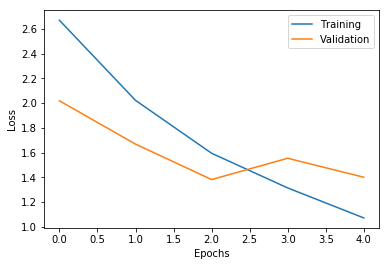

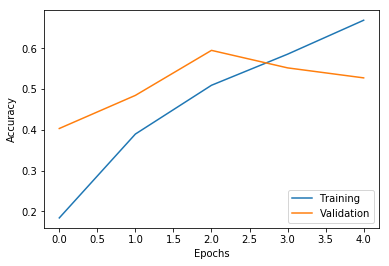

In [18]:
plot_history(history)

# Test

In [19]:
test_generator.reset()

pred=model.predict_generator(test_it,verbose=1, steps=179)

predicted_class_indices=np.argmax(pred,axis=1)


179/179 [==============================] - 11s 63ms/step


In [20]:
labels = (test_it.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_it.filenames
results=pd.DataFrame({"Filename":filenames,"Predictions":predictions})

# Valutazione modello

In [21]:
results

,Filename,Predictions
0,aeroplane/2008_000037.jpg,aeroplane
1,aeroplane/2008_000716.jpg,aeroplane
2,aeroplane/2008_002195.jpg,boat
3,aeroplane/2008_002221.jpg,aeroplane
4,aeroplane/2008_002719.jpg,aeroplane
5,aeroplane/2008_003041.jpg,car
6,aeroplane/2008_003196.jpg,aeroplane
7,aeroplane/2008_003703.jpg,aeroplane
8,aeroplane/2008_004165.jpg,aeroplane
9,aeroplane/2008_004739.jpg,boat


In [22]:
tot=0
for i in range(179):
    idx = results.Filename[i].find("/")
    sub = results.Filename[i][0:idx]
    if(sub==results.Predictions[i]):
        tot+=1
accuracy=(tot/179)*100
print("Test accuracy:")
print(accuracy)

Test accuracy:
53.072625698324025


# Salvataggio modello

In [23]:
model_name = 'VGG16_finet.h5'
model.save_weights(model_name)
model_json = model.to_json()
with open('VGG16_finet.json', 'w') as json_file:
    json_file.write(model_json)

# Alcuni esempi

In [24]:
classes=[]
for cl in Label:
    classes.append(cl)
classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

tvmonitor (0.708)


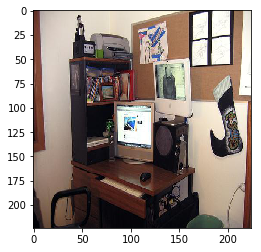

In [32]:
img = image.load_img(r'/content/drive/My Drive/multi_class_dataset/test/tvmonitor/2008_000348.jpg',target_size=(224, 224)) #read in image
img = image.img_to_array(img)
img = img/255

prediction = model.predict(np.array([img]))
top_3 = np.argsort(prediction[0])[:-2:-1]
for i in range(1):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(prediction[0][top_3[i]]))
plt.imshow(img)

bird (0.879)


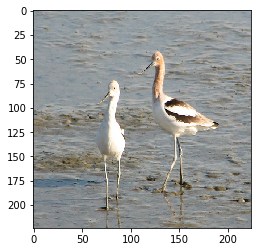

In [31]:
img = image.load_img(r'/content/drive/My Drive/multi_class_dataset/test/bird/2008_002961.jpg',target_size=(224, 224)) #read in image
img = image.img_to_array(img)
img = img/255

prediction = model.predict(np.array([img]))
top_3 = np.argsort(prediction[0])[:-2:-1]
for i in range(1):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(prediction[0][top_3[i]]))
plt.imshow(img)

train (0.957)


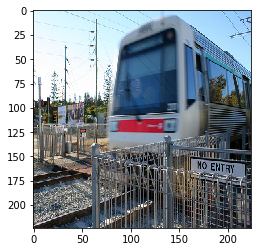

In [30]:
img = image.load_img(r'/content/drive/My Drive/multi_class_dataset/test/train/2008_008200.jpg',target_size=(224, 224)) #read in image
img = image.img_to_array(img)
img = img/255

prediction = model.predict(np.array([img]))
top_3 = np.argsort(prediction[0])[:-2:-1]
for i in range(1):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(prediction[0][top_3[i]]))
plt.imshow(img)

# Caricamento modello h5 con pesi

Per importare il modello utilizzato nelle prove compilare la seguente cella

In [ ]:
json_file = open('../Modelli_json/VGG16_finet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

model.load_weights(r"/content/drive/My Drive/VGG16_finet.h5")